In [2]:
import torch
import os, sys
config_path = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(config_path)

import config
import sklearn as sk
import pandas as pd
import seaborn as sns
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader


In [3]:
# Load the data
train_df = pd.read_csv(config.TITANIC_DIR / 'train.csv')


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\anten\\Documents\\GitHub\\Python-learning\\Data\\titanic\\train.csv'

In [ ]:
# Map the data

def map(df):
    df = df.copy()
    df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})
    df['Age'] = df['Age'].fillna(train_df['Age'].mean())            
    return df
    
train_df = map(train_df)

In [ ]:
# Seperate input features
features = list(train_df.columns)
features.remove('Ticket')
features.remove('PassengerId')
features.remove('Name')
features.remove('SibSp')
features.remove('Embarked')
features.remove('Cabin')

# Engineer Features
train_df['Name_len'] = train_df['Name'].str.len()



# Convert to tensors
print(f"Input features: {features}")
X_train = train_df[features]
y_train = train_df['Survived']

# Scale and Split

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
scaler = StandardScaler()
scaler.fit_transform(X_train)

X_train, X_test, y_train, y_test = train_test_split(X_train,y_train, test_size=0.2, random_state=42)


Input features: ['Survived', 'Pclass', 'Sex', 'Age', 'Parch', 'Fare']


In [ ]:
# Hyperparameters

learning_rate = .02
total_epochs = 1000
batch_size = 400
dropout_probability = 0.3


In [ ]:
X_train = torch.tensor(X_train.to_numpy(), dtype = torch.float32)
y_train = torch.tensor(y_train.to_numpy(), dtype = torch.long)
X_test  = torch.tensor(X_test.to_numpy(), dtype = torch.float32)
y_test  = torch.tensor(y_test.to_numpy(), dtype = torch.long)

train_dataset = TensorDataset(X_train, y_train)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)



In [ ]:
# Define the neural network model
class Titanicnet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(6, 128),
            nn.Hardswish(),
            nn.Dropout(p=dropout_probability),
            nn.Linear(128,64),
            nn.Hardswish(),
            nn.Dropout(p=dropout_probability),
            nn.Linear(64,16),
            nn.Hardswish(),
            nn.Dropout(p=dropout_probability),
            nn.Linear(16,8),
            nn.Hardswish(),
            nn.Dropout(p=dropout_probability),
            nn.Linear(8,2),
        )
    def forward(self, x):
        return self.net(x)
    
model = Titanicnet()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

loss_array = []

In [ ]:
# Training loop
def training_loop():
    last_avg = 0.0
    for epoch in range(1, total_epochs + 1):
        epoch_loss = 0.0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            loss_array.append(loss.item())
        if epoch % 10 == 0:
            avg = epoch_loss / len(train_loader)
            if abs(last_avg-avg) <= 5e-3 and avg <= .05:    # Early stopping if loss is no longer improving
                print(f'difference is {abs(last_avg-avg)}')
                print(f"Early stopping at epoch {epoch:5d}")
                break
            print(f"Epoch {epoch:5d} — avg batch loss: {avg:.4f}")
            last_avg = avg
import cProfile
cProfile.run('training_loop()', sort= 'cumtime')


Epoch    10 — avg batch loss: 0.6313
Epoch    20 — avg batch loss: 0.5703
Epoch    30 — avg batch loss: 0.2835
Epoch    40 — avg batch loss: 0.1809
Epoch    50 — avg batch loss: 0.1066
Epoch    60 — avg batch loss: 0.1169
Epoch    70 — avg batch loss: 0.1074
Epoch    80 — avg batch loss: 0.0600
Epoch    90 — avg batch loss: 0.0609
Epoch   100 — avg batch loss: 0.0806
Epoch   110 — avg batch loss: 0.0545
Epoch   120 — avg batch loss: 0.0761
Epoch   130 — avg batch loss: 0.0688
Epoch   140 — avg batch loss: 0.0566
Epoch   150 — avg batch loss: 0.0831
Epoch   160 — avg batch loss: 0.0976
Epoch   170 — avg batch loss: 0.0802
Epoch   180 — avg batch loss: 0.0509
difference is 0.002315858379006386
Early stopping at epoch   190
         1264639 function calls (1246532 primitive calls) in 1.297 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    1.297    1.297 {built-in method builtins.exec}
        1  

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
model.eval()
with torch.no_grad():
    out = model(X_test)
    predicted_labels = torch.argmax(out, dim=1).flatten()
    true_labels = y_test

    # Calculate accuracy
    accuracy = (predicted_labels == true_labels).sum().item() / len(y_test) * 100
    print(f"Accuracy: {accuracy:.4f}%")

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(true_labels, predicted_labels)
    print("Confusion Matrix:")
    print(conf_matrix)

    # Print classification report
    class_report = classification_report(true_labels, predicted_labels)
    print("\nClassification Report:")
    print(class_report)

Accuracy: 100.0000%
Confusion Matrix:
[[105   0]
 [  0  74]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       105
           1       1.00      1.00      1.00        74

    accuracy                           1.00       179
   macro avg       1.00      1.00      1.00       179
weighted avg       1.00      1.00      1.00       179



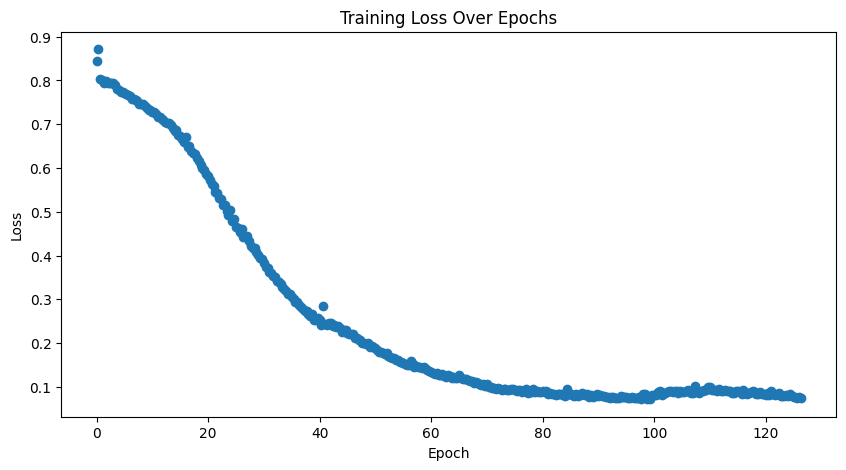

In [ ]:
loss_array_epochs = [i/3 for i in range(len(loss_array))]
for i in range (len(loss_array)):
    loss_array[i] = np.mean(loss_array[max(0,i-9):i+1])

plt.figure(figsize = (10,5))
plt.plot(loss_array_epochs, loss_array, marker = 'o', linestyle = '')
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(False)
plt.show()